# Tutorial PepFun

The following are a set of exercises to run some functionalities available in PepFun, which cover a set of bioinformatics and cheminformatics protocols for peptide analysis. In addition to this tutorial, the project contains a **test.py** script where many of the package functionalities are tested with basic examples. Here, we will cover some sequence- and structure-based analysis using one or many peptides at the same time. At the end, we will generate some libraries based on certain patterns and restraints.

* From publication "PepFun: open source protocols for peptide-related computational analysis"
* Molecules 
* Authors: Rodrigo Ochoa, Pilar Cossio
* Year: 2021

## Requirements

To run PepFun functionalities using Python3, it is recommended to configure a conda environment to have installed all the required dependencies **(which should be done only once)**. One way to create an initial virtual environment from the rdkit channel is:

`conda create -c rdkit -n pepfun-env rdkit biopython matplotlib scipy pip pycairo nb_conda_kernels`

For BioPython, it is recommended using version 1.76. After the installation, you can activate the environment using the command:

`source activate pepfun-env`

After entering the virtual environment, this notebook can be called with jupyter and selecting the kernel provided by this conda instance. Then, we can install the igraph module for python3.6 using pip:

`python3.6 -m pip install python-igraph`

**NOTES:**
1. If the script is called as a module from a different folder, the path can be added using the following commands (remove comments):

In [1]:
#import sys
#sys.path.append('<PATH-TO-PEPFUN>')

2. The package was build under a Unix environment, but it can be used under any other OS based on the provided paths

***

## 1. Sequence analysis

For this part, we will calculate a set of properties for a set of peptides reported as binders of the MHC class II allele DRB1\*0101, used as a benchmark system in the PepFun project. For that purpose, we will upload a list of sequences available in the tutorial:

*First we will import the modules required for the analysis*

In [2]:
# Modules of Pepfun
from pepfun import *

# Additional modules to run analysis
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from statistics import stdev
from scipy import stats

*The sequences can be loaded in a list object in python for further analysis. The file in the example contains the peptide sequences of the MHC class II binders with IC50 values below 50 uM*

In [3]:
sequences=[x.strip() for x in open("auxiliar/sequences_binders_50uM.txt")]

In [4]:
print("There is a total of {} sequences".format(len(sequences)))
print("The first peptide sequence is: {}".format(sequences[0]))

There is a total of 655 sequences
The first peptide sequence is: FWYVNHTGFNVHSLP


***

**1.1 Alignment examples with pair of peptides**

Initially we will compare two any sequences from the dataset using the functions provided in PepFun.

In [5]:
print("Query sequence is: {}".format(sequences[0]))
print("Subject sequence is: {}".format(sequences[1]))

Query sequence is: FWYVNHTGFNVHSLP
Subject sequence is: KALYDLQRSAMVYSS


Then we create the object and call a matrix to run the alignments

In [6]:
# Create object
pep=peptide_sequence(sequences[0])

# Call the matrix and run alignment position by position with the matrix
matrix=matlist.structure

With the new object, we can call the functions and calculate the corresponding scores:

In [7]:
pep.align_position_matrix(sequences[1],matrix)
print("Alignment score by position is: {}".format(pep.score_matrix))

# Run basic alignment position by position
pep.align_position_local(sequences[1])
print("The number of mismatches are: {}".format(pep.dismatch))

# Run local alignment with the matrix
similarity=pep.similarity_pair(sequences[0],sequences[1],matrix)
print("The similarity using a scoring matrix between peptides is: {0:.2f}".format(similarity))
    
# Compare the SMILES of the two sequences
pep.similar_smiles(sequences[1])
print("The SMILES similarity is: {0:.2f}".format(pep.smiles_similarity))

Alignment score by position is: -25
The number of mismatches are: 15
The similarity using a scoring matrix between peptides is: -0.29
The SMILES similarity is: 0.34


In the previous example, we have compared the two sequences using several methodologies. The alignment score by position is the sum of the match or mismatch scores based on the selected matrix. The number of mismatches are the amino acids that are not the same at the same position in the sequence. The similarity metric is a normalized score of the alignment, where the maximum value is 1. The SMILES similarity is a value (Tanimoto metric) between 0 an 1, the closes to 1, the more similar the sequence.

***

**1.2 Calculation of properties with the whole library**

In this part we will calculate four basic sequence properties: net charge, molecular weight, Crippen logP and Eisenberg's hydrophobicity (see paper for References). For that purpose, we will iterate over the sequences as follows:

In [8]:
# List with the properties
charges=[]
weights=[]
logps=[]
hydro=[]

# Loop over the sequences
for seq in sequences:
    # Create the object and run the calculations
    pep=peptide_sequence(seq)
    pep.compute_peptide_charges()
    pep.calculate_properties_from_mol()
    pep.calculate_properties_from_sequence()
    
    # Append the properties to the lists
    charges.append(pep.netCharge)
    weights.append(pep.mol_weight)
    logps.append(pep.mol_logp)
    hydro.append(pep.avg_hydro)

print("The number of peptides with properties calculated is: {}".format(len(charges)))

The number of peptides with properties calculated is: 655


The we can plot the properties as histograms using matplot functionalities. We will convert the lists to numpy arrays first:

In [9]:
chargesData=np.array(charges).astype(np.float)
weightsData=np.array(weights).astype(np.float)
logpsData=np.array(logps).astype(np.float)
hydroData=np.array(hydro).astype(np.float)

This is the histogram for the charges:

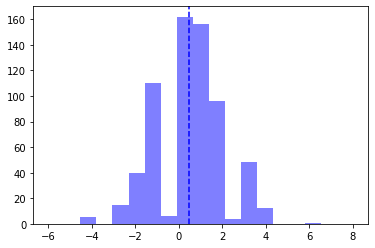

In [10]:
bins = np.linspace(-6,8,20)
plt.hist(chargesData, bins, alpha=0.5, color='b', linewidth=0)
plt.axvline(x=mean(charges), color='b', linestyle='--')
plt.show()

Hydrophobicity:

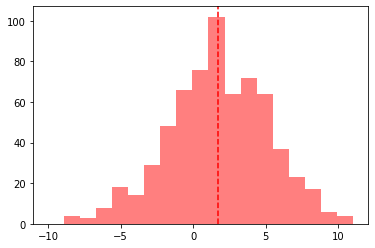

In [11]:
bins = np.linspace(-10,11,20)
plt.hist(hydroData, bins, alpha=0.5, color='r', linewidth=0)
plt.axvline(x=mean(hydro), color='r', linestyle='--')
plt.show()

Molecular weight:

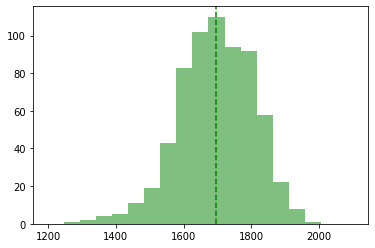

In [12]:
bins = np.linspace(1200,2100,20)
plt.hist(weightsData, bins, alpha=0.5, color='g', linewidth=0)
plt.axvline(x=mean(weights), color='g', linestyle='--')
plt.show()

and Crippen logP:

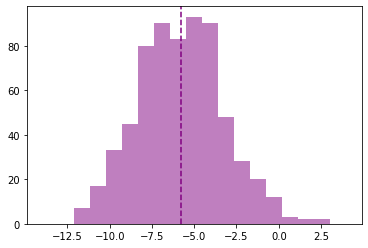

In [13]:
bins = np.linspace(-14,4,20)
plt.hist(logpsData, bins, alpha=0.5, color='purple', linewidth=0)
plt.axvline(x=mean(logps), color='purple', linestyle='--')
plt.show()

***

## 2. Structure analysis

In this section we will calculate a number of interactions for a protease-peptide complex presented in the Results section of the paper. First, we will upload the structure:

In [14]:
pdb_file="auxiliar/protease_structure.pdb"
dssp_route="auxiliar/mkdssp"
chain="B"
pepStr=peptide_structure(pdb_file,chain)
print("The peptide sequence based on the PDB file is: {}\n".format(pepStr.sequence))

The peptide sequence based on the PDB file is: IEPDTDAP



Based on the structural conformation of the peptide, we can calculate the secondary structure

In [15]:
pepStr.get_secondary_structure(dssp_route)
print("The predicted secondary structure is: {}".format(pepStr.total_dssp))

#The secondary structure convention in DSSP is:
#    B - beta bridge
#    H - alpha helix
#    E - beta strand
#    S - bend
#    T - turn
#    G - 3/10 helix

The predicted secondary structure is: -EESS---


Then, we can calculate the number of contacts after establishing a contact threshold:

In [16]:
contact_threshold=4.0
pepStr.get_heavy_atom_contacts(contact_threshold)
print("The total number of contacts is: {}".format(pepStr.total_contacts))

The total number of contacts is: 118


Then we can calculate the hydrogen bonds based on DSSP:

These are the hydrogen bonds detected:
I1 interacts with residue G200 from chain A
I1 interacts with residue S198 from chain A
E2 interacts with residue Y199 from chain A
E2 interacts with residue Y199 from chain A
E2 interacts with residue N84 from chain A
P3 interacts with residue S198 from chain A
D4 interacts with residue V197 from chain A
D4 interacts with residue D182 from chain A
D4 interacts with residue F179 from chain A
D4 interacts with residue K180 from chain A
T5 interacts with residue G181 from chain A
T5 interacts with residue F179 from chain A
T5 interacts with residue R28 from chain A
D6 interacts with residue K27 from chain A
D6 interacts with residue K180 from chain A
A7 interacts with residue F179 from chain A
The total number of hydrogen bonds are: 16


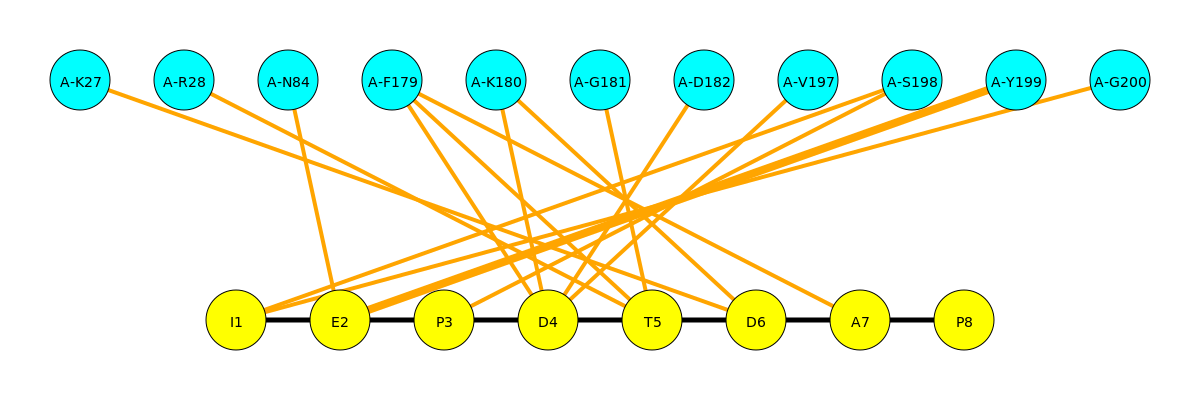

In [17]:
pepStr.get_hydrogen_bonds(dssp_route)
print("The total number of hydrogen bonds are: {}".format(pepStr.number_hydrogen_bonds))
    
#The hydrogen bonds can be plotted in a linear or cyclic conformation using the function
pepStr.plot_hydrogen_bonds("linear")
from IPython.display import Image
Image(filename='plot_hbs_IEPDTDAP.png')

Finally, we can check amino acid by amino acid in the peptide what is the accesible surface area (ASA) value, as well as the specific contacts created by each residue:

In [18]:
print("The following are the details per amino acid in the peptide:")
print("AA\tPos\tASA\tContacts")
for position in pepStr.positions:
    print("{:s}\t{:d}\t{:.2f}\t{:d}".format(pepStr.positions[position]['aa'],position,
          pepStr.positions[position]['asa'],pepStr.positions[position]['contacts']))

The following are the details per amino acid in the peptide:
AA	Pos	ASA	Contacts
I	1	0.30	16
E	2	0.42	13
P	3	0.14	16
D	4	0.02	42
T	5	0.02	15
D	6	0.18	16
A	7	0.45	0
P	8	1.00	0


***

## 3. Generation of libraries

In this part, we will generate two independent libraries. For the first case, we will create a library of 10-mer peptides with a similar distribution of the natural amino acids in all the positions of the peptide:

In [19]:
list_peptides=combinatorial_library(10,"natural")

We can check what is the distribution of **Alanine** at each position of the peptide. If the distribution is uniform, the percentage should be around 5%

In [20]:
counter=frequencies_library(list_peptides)

for pos in counter:
    count_alanine=counter[pos]['A']
    total=0
    for aa in counter[pos]:
        total+=counter[pos][aa]
    perc_alanine=float(count_alanine)/float(total)*100
    print("ALA% for position {:d} is: {:.2f}".format(pos,perc_alanine))

ALA% for position 1 is: 5.33
ALA% for position 2 is: 5.67
ALA% for position 3 is: 3.33
ALA% for position 4 is: 4.00
ALA% for position 5 is: 4.83
ALA% for position 6 is: 5.67
ALA% for position 7 is: 4.17
ALA% for position 8 is: 5.33
ALA% for position 9 is: 4.50
ALA% for position 10 is: 4.83


In the second example, we will generate a library of 5-mer peptides with pattern "XERTX". The pattern means that the ERT motif will be conserved, and the X positions will be changed with all the amino acids. Based on the combinations, a total of 400 peptides should be generated.

In [21]:
list_peptides=generate_peptide_pattern("XERTX")
print("The total amount of peptides in the library is {}".format(len(list_peptides)))

The total amount of peptides in the library is 400


***

## Support

For any questions, and developer feedback, please contact us to the email: rodrigo.ochoa@udea.edu.co